# Importações

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

from itertools import cycle, islice

import warnings
warnings.simplefilter(action='ignore')

# Definições Básicas

## Distâncias

In [ ]:
def minkowski_distance(x, y, p=2):
    """
    Calcula a distância de Minkowski entre dois pontos.

    Parâmetros:
    - x: array-like, forma (n_features,)
        Coordenadas do primeiro ponto.
    - y: array-like, forma (n_features,)
        Coordenadas do segundo ponto.
    - p: int, opcional (default=2)
        Parâmetro que define o tipo de distância de Minkowski.
        Para p=1, temos a distância Manhattan.
        Para p=2, temos a distância Euclidiana.
        Para valores maiores de p, temos outras variações da distância de Minkowski.

    Retorna:
    - float: A distância de Minkowski entre os dois pontos.
    """
    return np.sum(np.abs(x - y) ** p) ** (1 / p)

# Função para calcular o raio inicial baseado na média das distâncias
def calculate_initial_radius(X, sample_size=None):
    if sample_size and sample_size < X.shape[0]:
        X = X[np.random.choice(X.shape[0], sample_size, replace=False)]
    distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
    mean_distance = np.mean(distances)
    return mean_distance / 3  # Raio inicial como um terço da distância média

## Algoritmos 2-Aproximados

In [ ]:
def two_approx_k_center_fixed_radius(points, radius, p=2):
    """
    Executa o algoritmo 2-aproximado para o problema de k-center com raio fixo.

    Parâmetros:
    - points: array-like, forma (n_samples, n_features)
        Conjunto de pontos a serem agrupados.
    - radius: float
        Raio fixo usado para definir se um ponto deve ser incluído em um cluster existente ou formar um novo.
    - p: int, opcional (default=2)
        Parâmetro da distância de Minkowski a ser usada para calcular as distâncias entre pontos.

    Retorna:
    - list: Lista de centros dos clusters identificados pelo algoritmo.
    """
    centers = [points[0]]  # Inicializa o primeiro centro com o primeiro ponto
    for point in points:
        # Verifica se o ponto está fora do raio de todos os centros atuais
        if all(minkowski_distance(point, center, p=p) > radius for center in centers):
            centers.append(point)  # Adiciona um novo centro
    return centers

def two_approx_k_center_refined_radius(points, initial_radius, refinement_factor=1.25, max_iters=10, p=2):
    """
    Executa o algoritmo 2-aproximado para o problema de k-center com refinamento de raio.

    Parâmetros:
    - points: array-like, forma (n_samples, n_features)
        Conjunto de pontos a serem agrupados.
    - initial_radius: float
        Raio inicial a partir do qual o refinamento começa.
    - refinement_factor: float, opcional (default=1.25)
        Fator pelo qual o raio é refinado em cada iteração. Um valor menor refina mais agressivamente.
    - max_iters: int, opcional (default=10)
        Número máximo de iterações de refinamento.
    - p: int, opcional (default=2)
        Parâmetro da distância de Minkowski a ser usada para calcular as distâncias entre pontos.

    Retorna:
    - list: Lista de centros dos clusters identificados após o refinamento do raio.
    """
    radius = initial_radius  # Define o raio inicial
    for _ in range(max_iters):
        centers = two_approx_k_center_fixed_radius(points, radius, p=p)
        radius /= refinement_factor  # Refina o raio dividindo pelo fator
    return centers

## Avaliação

In [ ]:
def evaluate_clustering(points, centers, p=2, true_labels=None):
    """
    Avalia a qualidade de um agrupamento (clustering) utilizando métricas de Silhueta e Índice Rand Ajustado (ARI).

    Parâmetros:
    - points: array-like, forma (n_samples, n_features)
        Conjunto de pontos que foram agrupados.
    - centers: array-like, forma (n_clusters, n_features)
        Lista de centros dos clusters gerados pelo algoritmo de agrupamento.
    - p: int, opcional (default=2)
        Parâmetro da distância de Minkowski a ser usada para calcular as distâncias entre pontos e centros.
        Para p=2, calcula a distância Euclidiana.
        Para p=1, calcula a distância Manhattan.
        Para outros valores, calcula a distância Minkowski correspondente.
    - true_labels: array-like, forma (n_samples,), opcional
        Labels verdadeiras dos dados, necessárias para o cálculo do ARI. Se não fornecido, o ARI não será calculado.

    Retorna:
    - tuple:
        - silhouette: float
            A métrica de Silhueta, variando de -1 a 1, onde valores mais altos indicam que os pontos estão bem correspondidos ao seu cluster.
        - ari: float ou None
            O Índice Rand Ajustado (ARI), uma métrica de similaridade que mede a concordância entre diferentes agrupamentos, variando de -1 a 1. Retorna None se true_labels não for fornecido.
    """
    if p == 2:
        distances = np.linalg.norm(points[:, np.newaxis] - centers, axis=2)
    else:
        distances = np.sum(np.abs(points[:, np.newaxis] - centers) ** p, axis=2) ** (1 / p)

    labels = np.argmin(distances, axis=1)

    silhouette = silhouette_score(points, labels)

    if true_labels is not None:
        ari = adjusted_rand_score(true_labels, labels)
    else:
        ari = None

    return silhouette, ari

# Dados Sintéticos 1

### All-in-One

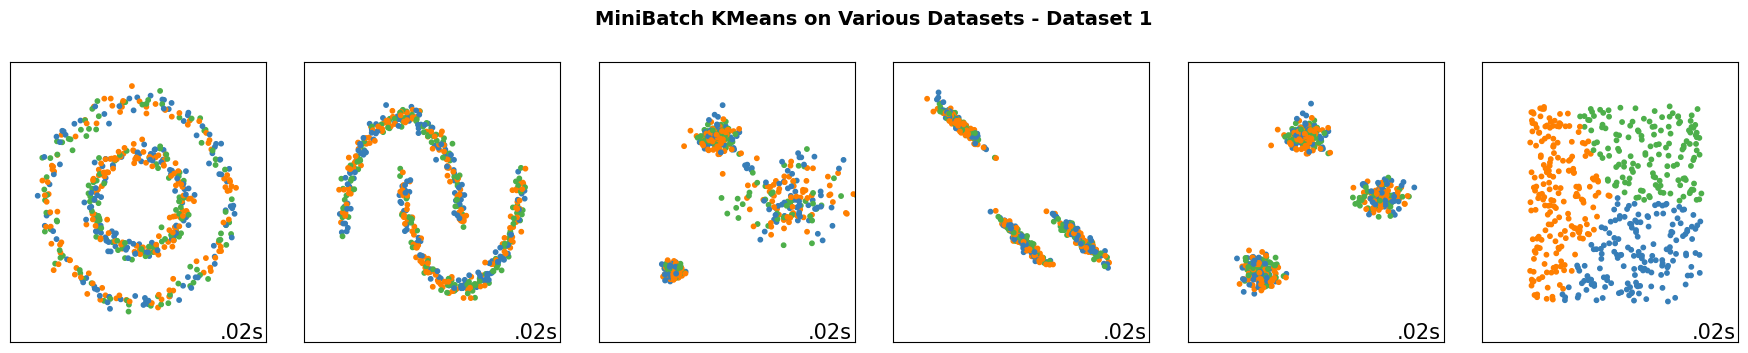

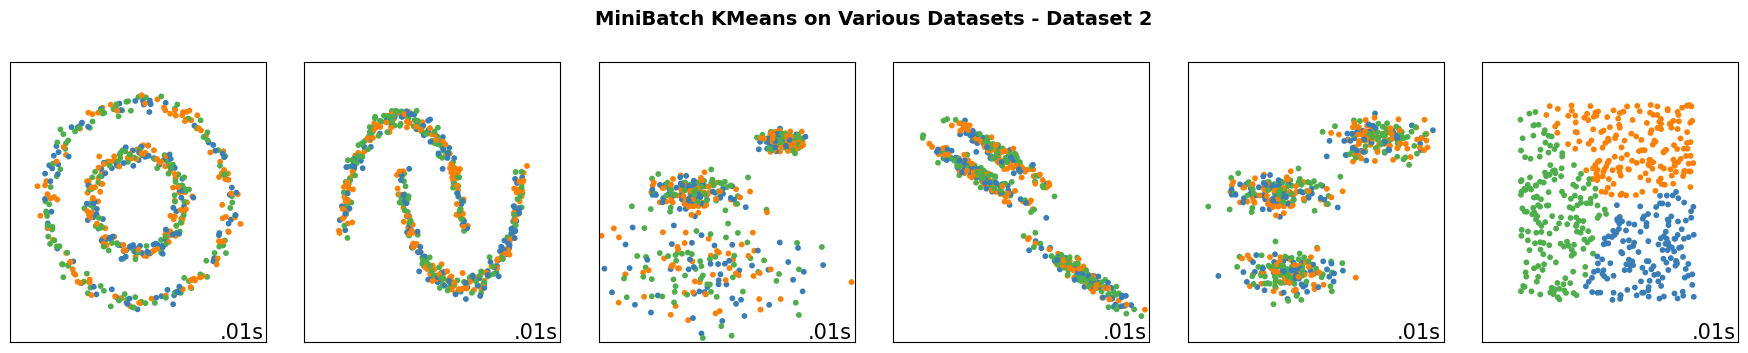

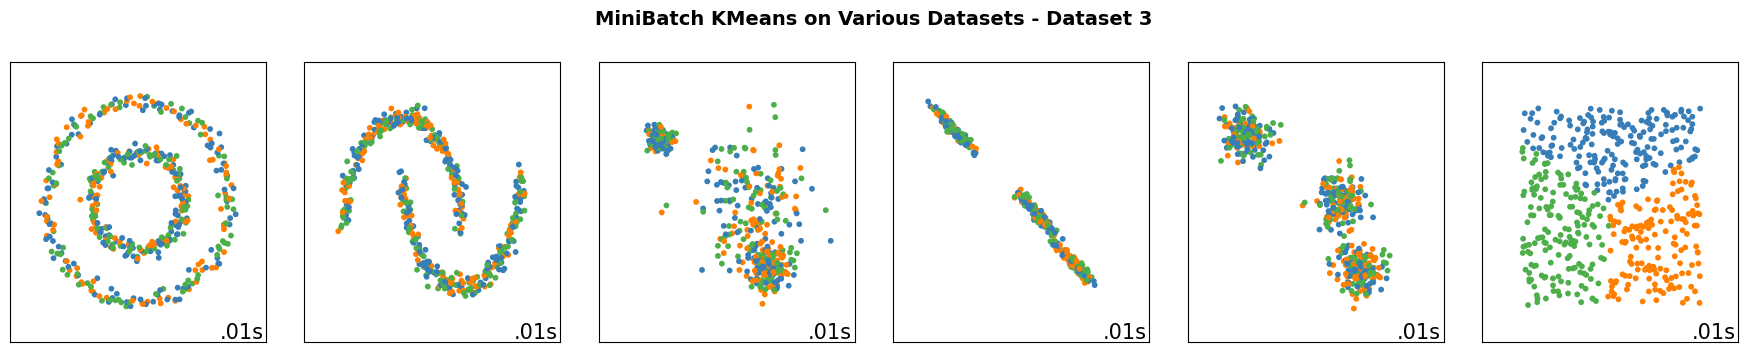

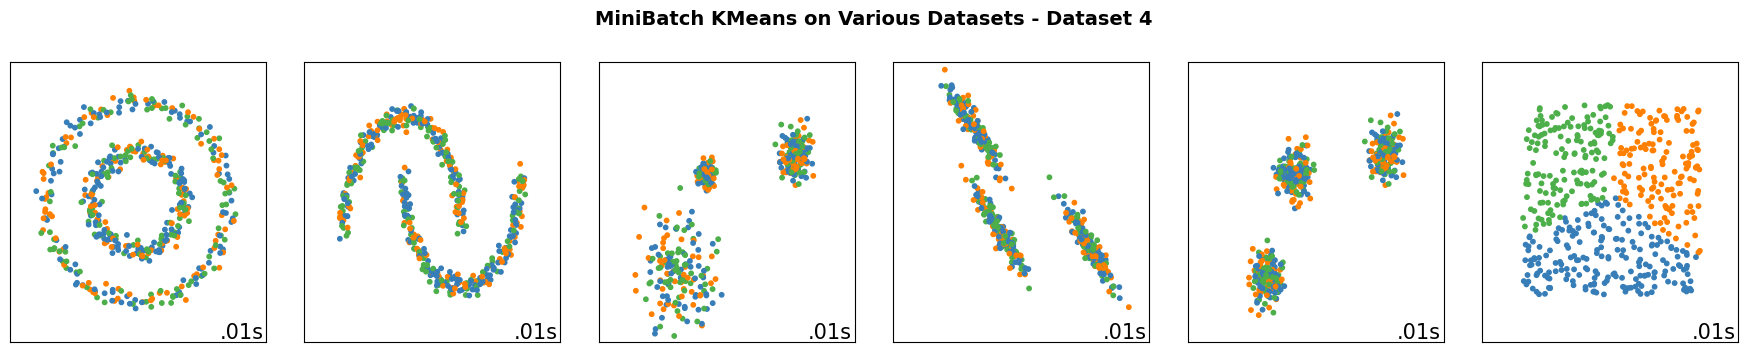

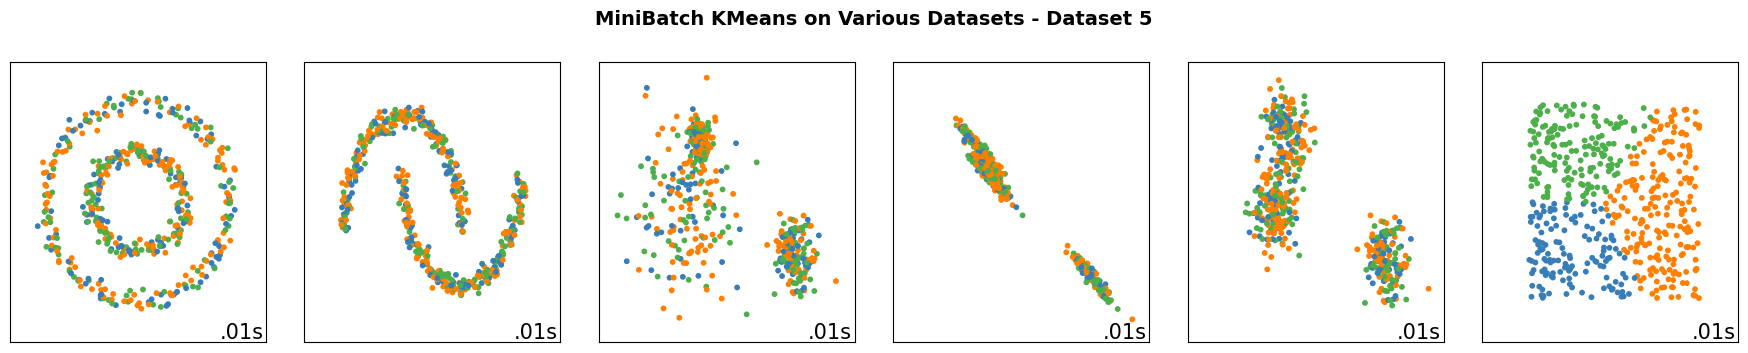

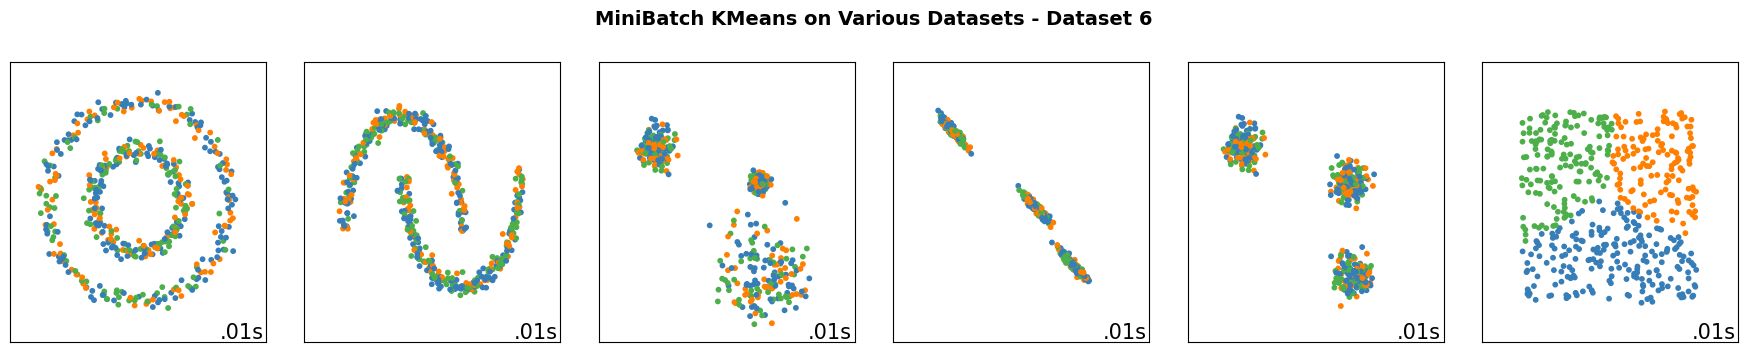

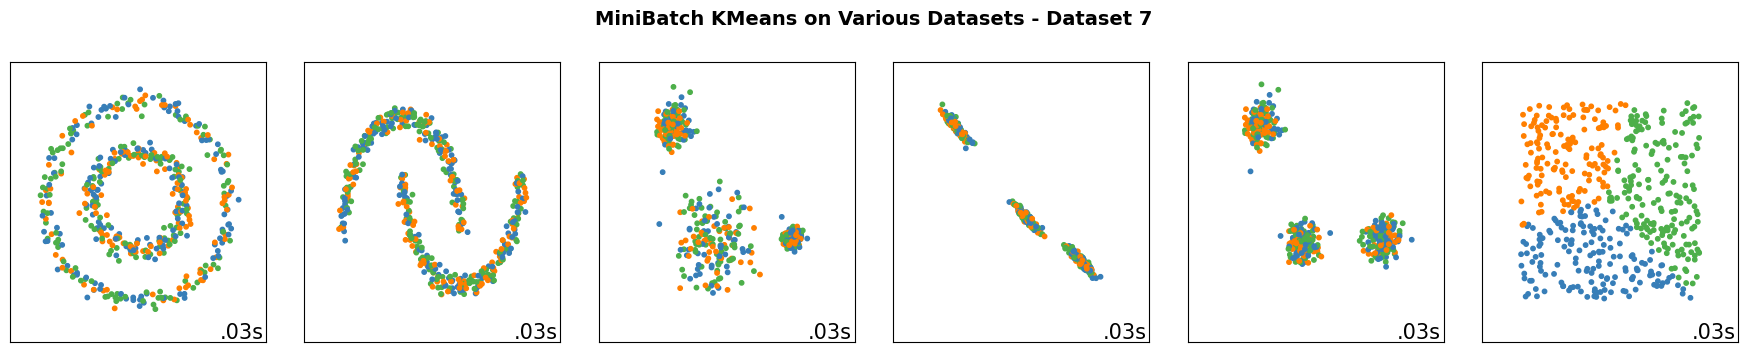

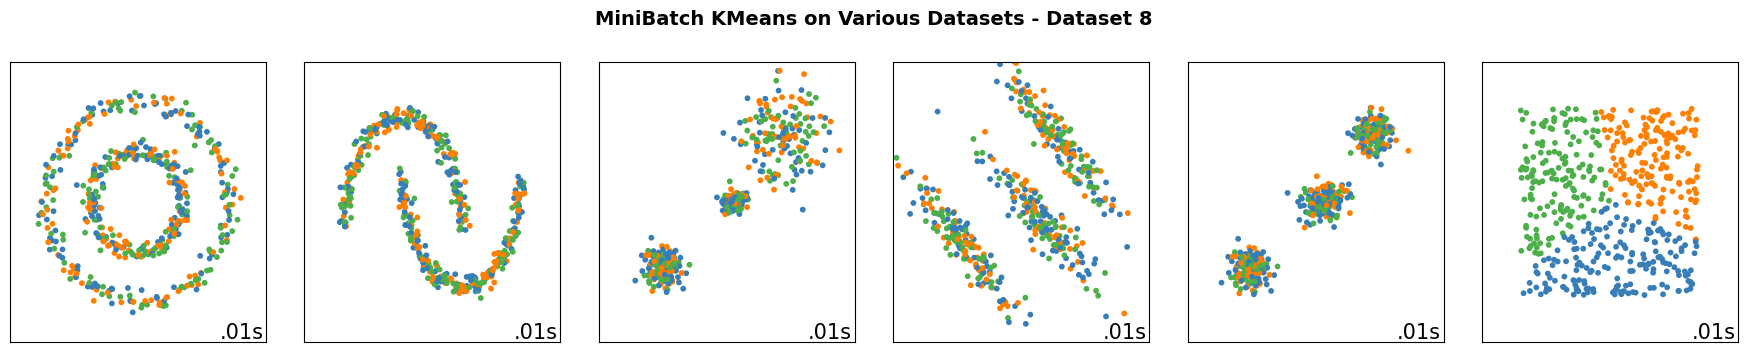

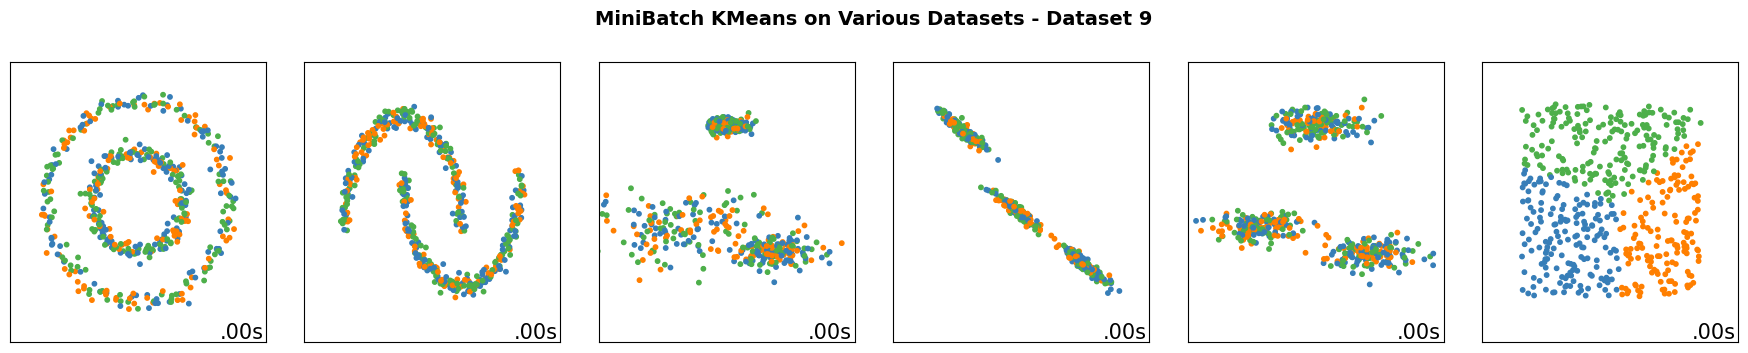

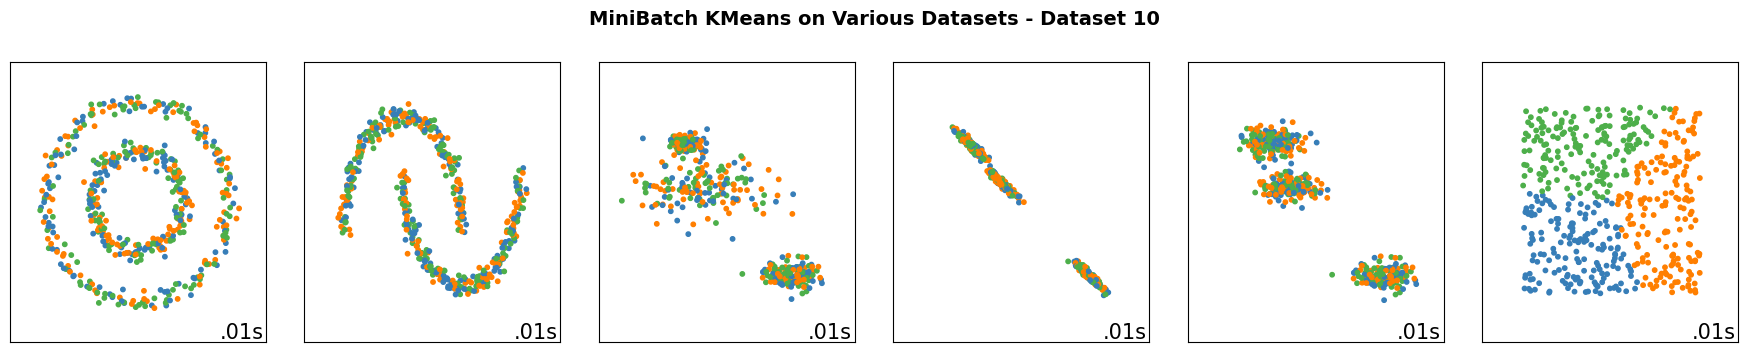

Dataset 1: Average execution time over 30 runs: 0.0081 seconds
Dataset 2: Average execution time over 30 runs: 0.0061 seconds
Dataset 3: Average execution time over 30 runs: 0.0055 seconds
Dataset 4: Average execution time over 30 runs: 0.0071 seconds
Dataset 5: Average execution time over 30 runs: 0.0187 seconds
Dataset 6: Average execution time over 30 runs: 0.0126 seconds
Dataset 7: Average execution time over 30 runs: 0.0139 seconds
Dataset 8: Average execution time over 30 runs: 0.0091 seconds
Dataset 9: Average execution time over 30 runs: 0.0076 seconds
Dataset 10: Average execution time over 30 runs: 0.0058 seconds


In [ ]:
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler

# ============
# Parameters for the experiment
# ============
n_samples = 500
n_datasets = 10
n_executions = 30
fixed_seed = 42  # Usar um random_state fixo para maior consistência

# Lista para armazenar os tempos médios de execução para cada conjunto de dados
average_times = []

# Loop para 10 diferentes conjuntos de dados
for dataset_index in range(n_datasets):
    # Gerar conjuntos de dados com um seed fixo para consistência
    noisy_circles = datasets.make_circles(
        n_samples=n_samples, factor=0.5, noise=0.05, random_state=fixed_seed + dataset_index
    )
    noisy_moons = datasets.make_moons(
        n_samples=n_samples, noise=0.05, random_state=fixed_seed + dataset_index
    )
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=fixed_seed + dataset_index)
    rng = np.random.RandomState(fixed_seed + dataset_index)
    no_structure = rng.rand(n_samples, 2), None

    random_state = fixed_seed + dataset_index
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    varied = datasets.make_blobs(
        n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
    )

    datasets_list = [
        noisy_circles,
        noisy_moons,
        varied,
        aniso,
        blobs,
        no_structure,
    ]

    # Armazenar o tempo total de execução para este conjunto de dados
    total_time = 0

    # Executar 30 vezes para cada conjunto de dados
    for execution_index in range(n_executions):
        for i_dataset, dataset in enumerate(datasets_list):
            X, y = dataset

            # Normalizar o conjunto de dados para facilitar a seleção de parâmetros
            X = StandardScaler().fit_transform(X)

            # MiniBatch KMeans com random_state fixo
            two_means = cluster.MiniBatchKMeans(
                n_clusters=3, random_state=fixed_seed
            )

            t0 = time.time()

            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the "
                    + "connectivity matrix is [0-9]{1,2}"
                    + " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning,
                )
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding"
                    + " may not work as expected.",
                    category=UserWarning,
                )
                two_means.fit(X)

            t1 = time.time()
            total_time += (t1 - t0)

    # Calcular o tempo médio de execução para este conjunto de dados
    average_time = total_time / (n_executions * len(datasets_list))
    average_times.append(average_time)

    # Plotar os resultados da última execução
    plt.figure(figsize=(18, 4))  # Largura maior para suportar plots horizontais
    plt.subplots_adjust(
        left=0.02, right=0.98, bottom=0.15, top=0.85, wspace=0.15, hspace=0.05
    )
    plt.suptitle(
        f"MiniBatch KMeans on Various Datasets - Dataset {dataset_index + 1}",
        fontsize=14,
        fontweight="bold",
    )

    plot_num = 1
    for i_dataset, dataset in enumerate(datasets_list):
        X, y = dataset
        X = StandardScaler().fit_transform(X)

        y_pred = two_means.labels_.astype(int)

        plt.subplot(1, len(datasets_list), plot_num)

        colors = np.array(
            [
                "#377eb8",
                "#ff7f00",
                "#4daf4a",
                "#f781bf",
                "#a65628",
                "#984ea3",
                "#999999",
                "#e41a1c",
                "#dede00",
            ]
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

    plt.show()

# Exibir os tempos médios de execução
for i, avg_time in enumerate(average_times):
    print(f"Dataset {i + 1}: Average execution time over {n_executions} runs: {avg_time:.4f} seconds")


In [ ]:
import time
import numpy as np
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score

# ============
# Parameters for the experiment
# ============
n_samples = 500
n_datasets = 5
n_executions = 3
fixed_seed = 42  # Usar um random_state fixo para maior consistência

# Lista para armazenar os resultados
results = []

# Loop para diferentes conjuntos de dados
for dataset_index in range(n_datasets):
    # Gerar conjuntos de dados com um seed fixo para consistência
    noisy_circles = datasets.make_circles(
        n_samples=n_samples, factor=0.5, noise=0.05, random_state=fixed_seed + dataset_index
    )
    noisy_moons = datasets.make_moons(
        n_samples=n_samples, noise=0.05, random_state=fixed_seed + dataset_index
    )
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=fixed_seed + dataset_index)
    rng = np.random.RandomState(fixed_seed + dataset_index)
    no_structure = rng.rand(n_samples, 2), None

    random_state = fixed_seed + dataset_index
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    varied = datasets.make_blobs(
        n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
    )

    datasets_list = [
        noisy_circles,
        noisy_moons,
        varied,
        aniso,
        blobs,
        no_structure,
    ]

    for i_dataset, dataset in enumerate(datasets_list):
        X, y = dataset

        # Normalizar o conjunto de dados
        X = StandardScaler().fit_transform(X)

        for p in [1, 2]:
            # 1. Método do raio fixo
            silhouette_fixed_list = []
            ari_fixed_list = []
            time_fixed_list = []
            initial_radius = calculate_initial_radius(X) * (5 if p == 1 else 2)

            for execution_index in range(n_executions):
                start_time = time.time()
                centers_fixed = two_approx_k_center_fixed_radius(X, radius=initial_radius, p=p)
                time_fixed = time.time() - start_time

                if len(centers_fixed) >= 2:
                    silhouette_fixed, ari_fixed = evaluate_clustering(X, centers_fixed, p=p)
                    silhouette_fixed_list.append(silhouette_fixed)
                    ari_fixed_list.append(ari_fixed)
                    time_fixed_list.append(time_fixed)

            # Armazenar resultados do raio fixo
            results.append({
                'dataset_index': dataset_index,
                'dataset_type': i_dataset,
                'p': p,
                'method': 'fixed_radius',
                'radius': initial_radius,
                'silhouette': np.mean(silhouette_fixed_list),
                'ari': None,
                'time': np.mean(time_fixed_list)
            })

            # 2. Método com refinamento de raio
            for rf in [1.01, 1.05, 1.1, 1.15, 1.25]:
                silhouette_refined_list = []
                ari_refined_list = []
                time_refined_list = []

                for execution_index in range(n_executions):
                    start_time = time.time()
                    centers_refined = two_approx_k_center_refined_radius(X, initial_radius=initial_radius, refinement_factor=rf, max_iters=3, p=p)
                    time_refined = time.time() - start_time

                    if len(centers_refined) >= 2:
                        silhouette_refined, ari_refined = evaluate_clustering(X, centers_refined, p=p)
                        silhouette_refined_list.append(silhouette_refined)
                        ari_refined_list.append(ari_refined)
                        time_refined_list.append(time_refined)

                # Armazenar resultados do refinamento
                results.append({
                    'dataset_index': dataset_index,
                    'dataset_type': i_dataset,
                    'p': p,
                    'method': 'refined_radius',
                    'radius': initial_radius,  # Aqui o raio inicial, que foi refinado
                    'refinement_factor': rf,
                    'silhouette': np.mean(silhouette_refined_list),
                    'ari': None,
                    'time': np.mean(time_refined_list)
                })

            # 3. Método do scikit-learn (MiniBatchKMeans)
            silhouette_kmeans_list = []
            ari_kmeans_list = []
            time_kmeans_list = []

            for execution_index in range(n_executions):
                start_time = time.time()
                kmeans = cluster.MiniBatchKMeans(n_clusters=3, random_state=fixed_seed)
                kmeans.fit(X)
                time_kmeans = time.time() - start_time
                silhouette_kmeans, ari_kmeans = evaluate_clustering(X, kmeans.cluster_centers_, p=p)

                silhouette_kmeans_list.append(silhouette_kmeans)
                ari_kmeans_list.append(ari_kmeans)
                time_kmeans_list.append(time_kmeans)

            # Armazenar resultados do k-means
            results.append({
                'dataset_index': dataset_index,
                'dataset_type': i_dataset,
                'p': p,
                'method': 'kmeans',
                'radius': None,  # KMeans não usa raio
                'silhouette': np.mean(silhouette_kmeans_list),
                'ari': None,
                'time': np.mean(time_kmeans_list)
            })

# Exibir os resultados
for result in results:
    print(result)

{'dataset_index': 0, 'dataset_type': 0, 'p': 1, 'method': 'fixed_radius', 'radius': 3.0097888189510997, 'silhouette': 0.34746408180503124, 'ari': None, 'time': 0.008820931116739908}
{'dataset_index': 0, 'dataset_type': 0, 'p': 1, 'method': 'refined_radius', 'radius': 3.0097888189510997, 'refinement_factor': 1.01, 'silhouette': 0.34746408180503124, 'ari': None, 'time': 0.04013411204020182}
{'dataset_index': 0, 'dataset_type': 0, 'p': 1, 'method': 'refined_radius', 'radius': 3.0097888189510997, 'refinement_factor': 1.05, 'silhouette': 0.34746408180503124, 'ari': None, 'time': 0.050918261210123696}
{'dataset_index': 0, 'dataset_type': 0, 'p': 1, 'method': 'refined_radius', 'radius': 3.0097888189510997, 'refinement_factor': 1.1, 'silhouette': 0.3239566557812169, 'ari': None, 'time': 0.053084214528401695}
{'dataset_index': 0, 'dataset_type': 0, 'p': 1, 'method': 'refined_radius', 'radius': 3.0097888189510997, 'refinement_factor': 1.15, 'silhouette': 0.33228299131146083, 'ari': None, 'time':

### Gerar Conjunto de Dados

In [ ]:
def generate_datasets(n_samples=500, seed=None):
    rng = np.random.RandomState(seed)
    noisy_circles = datasets.make_circles(
        n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
    )
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
    no_structure = rng.rand(n_samples, 2), None

    # Anisotropicly distributed data
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=seed)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    # blobs with varied variances
    varied = datasets.make_blobs(
        n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=seed
    )

    return [
        (noisy_circles, {"damping": 0.77, "preference": -240, "quantile": 0.2, "n_clusters": 2, "min_samples": 7, "xi": 0.08}),
        (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2, "min_samples": 7, "xi": 0.1}),
        (varied, {"eps": 0.18, "n_neighbors": 2, "min_samples": 7, "xi": 0.01, "min_cluster_size": 0.2}),
        (aniso, {"eps": 0.15, "n_neighbors": 2, "min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
        (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
        (no_structure, {}),
    ]

### Executar os Algoritmos

In [ ]:
def run_clustering_algorithms(datasets, params, show_plots=False):
    plot_num = 1
    if show_plots:
        plt.figure(figsize=(18, 13))
        plt.subplots_adjust(
            left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
        )

    for i_dataset, (dataset, algo_params) in enumerate(datasets):
        # Atualização dos parâmetros específicos para o dataset
        current_params = params.copy()
        current_params.update(algo_params)

        X, y = dataset

        # Normalização dos dados
        X = StandardScaler().fit_transform(X)

        # Estimativa da largura de banda para MeanShift
        bandwidth = cluster.estimate_bandwidth(X, quantile=current_params["quantile"])

        # Matriz de conectividade para Ward estruturado
        connectivity = kneighbors_graph(
            X, n_neighbors=current_params["n_neighbors"], include_self=False
        )
        connectivity = 0.5 * (connectivity + connectivity.T)

        # Criação dos objetos de clustering
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(
            n_clusters=current_params["n_clusters"],
            random_state=current_params["random_state"],
        )
        ward = cluster.AgglomerativeClustering(
            n_clusters=current_params["n_clusters"], linkage="ward", connectivity=connectivity
        )
        spectral = cluster.SpectralClustering(
            n_clusters=current_params["n_clusters"],
            eigen_solver="arpack",
            affinity="nearest_neighbors",
            random_state=current_params["random_state"],
        )
        dbscan = cluster.DBSCAN(eps=current_params["eps"])
        hdbscan = cluster.HDBSCAN(
            min_samples=current_params["hdbscan_min_samples"],
            min_cluster_size=current_params["hdbscan_min_cluster_size"],
            allow_single_cluster=current_params["allow_single_cluster"],
        )
        optics = cluster.OPTICS(
            min_samples=current_params["min_samples"],
            xi=current_params["xi"],
            min_cluster_size=current_params["min_cluster_size"],
        )
        affinity_propagation = cluster.AffinityPropagation(
            damping=current_params["damping"],
            preference=current_params["preference"],
            random_state=current_params["random_state"],
        )
        average_linkage = cluster.AgglomerativeClustering(
            linkage="average",
            metric="cityblock",
            n_clusters=current_params["n_clusters"],
            connectivity=connectivity,
        )
        birch = cluster.Birch(n_clusters=current_params["n_clusters"])
        gmm = mixture.GaussianMixture(
            n_components=current_params["n_clusters"],
            covariance_type="full",
            random_state=current_params["random_state"],
        )

        clustering_algorithms = (
            ("MiniBatch\nKMeans", two_means),
            ("Affinity\nPropagation", affinity_propagation),
            ("MeanShift", ms),
            ("Spectral\nClustering", spectral),
            ("Ward", ward),
            ("Agglomerative\nClustering", average_linkage),
            ("DBSCAN", dbscan),
            ("HDBSCAN", hdbscan),
            ("OPTICS", optics),
            ("BIRCH", birch),
            ("Gaussian\nMixture", gmm),
        )

        for name, algorithm in clustering_algorithms:
            t0 = time.time()
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the connectivity matrix is [0-9]{1,2}"
                    + " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning,
                )
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding"
                    + " may not work as expected.",
                    category=UserWarning,
                )
                algorithm.fit(X)

            t1 = time.time()
            if hasattr(algorithm, "labels_"):
                y_pred = algorithm.labels_.astype(int)
            else:
                y_pred = algorithm.predict(X)

            if show_plots:
                plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
                if i_dataset == 0:
                    plt.title(name, size=18)

                colors = np.array(
                    list(
                        islice(
                            cycle(
                                [
                                    "#377eb8",
                                    "#ff7f00",
                                    "#4daf4a",
                                    "#f781bf",
                                    "#a65628",
                                    "#984ea3",
                                    "#999999",
                                    "#e41a1c",
                                    "#dede00",
                                ]
                            ),
                            int(max(y_pred) + 1),
                        )
                    )
                )
                colors = np.append(colors, ["#000000"])
                plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

                plt.xlim(-2.5, 2.5)
                plt.ylim(-2.5, 2.5)
                plt.xticks(())
                plt.yticks(())
                plt.text(
                    0.99,
                    0.01,
                    ("%.2fs" % (t1 - t0)).lstrip("0"),
                    transform=plt.gca().transAxes,
                    size=15,
                    horizontalalignment="right",
                )
                plot_num += 1

    if show_plots:
        plt.show()

### Definição dos Parâmetros

In [ ]:
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

### Geração dos 10 Conjuntos de Dados

# Dados Sintéticos 2

### Gerar Conjunto de Dados

In [ ]:
# Função para gerar dados sintéticos com distribuição normal multivariada
def generate_multivariate_normal_data(n_samples=300, centers=5, cluster_std=1.0, n_features=2):
    """
    Gera dados sintéticos distribuídos conforme uma distribuição normal multivariada.

    Parâmetros:
    - n_samples: int, opcional (default=300)
        Número total de amostras a serem geradas.
    - centers: int, opcional (default=5)
        Número de centros ou clusters que os dados devem formar.
    - cluster_std: float, opcional (default=1.0)
        Desvio padrão dos clusters, controlando o quão espalhados os dados estão em torno do centro.
    - n_features: int, opcional (default=2)
        Número de características (dimensões) dos dados gerados.

    Retorna:
    - X: ndarray, forma (n_samples, n_features)
        Dados gerados, onde cada linha representa uma amostra.
    - y: ndarray, forma (n_samples,)
        Rótulos dos clusters correspondentes para cada amostra gerada.
    """
    np.random.seed(42)
    X = []
    y = []

    for i in range(centers):
        mean = np.random.rand(n_features) * 10  # Aleatório entre 0 e 10
        cov = np.diag(np.random.rand(n_features) * cluster_std)  # Diagonal com variâncias diferentes
        cluster_data = np.random.multivariate_normal(mean, cov, n_samples // centers)
        X.append(cluster_data)
        y += [i] * (n_samples // centers)

    X = np.vstack(X)
    y = np.array(y)
    return X, y

### Geração dos 10 Conjuntos de Dados

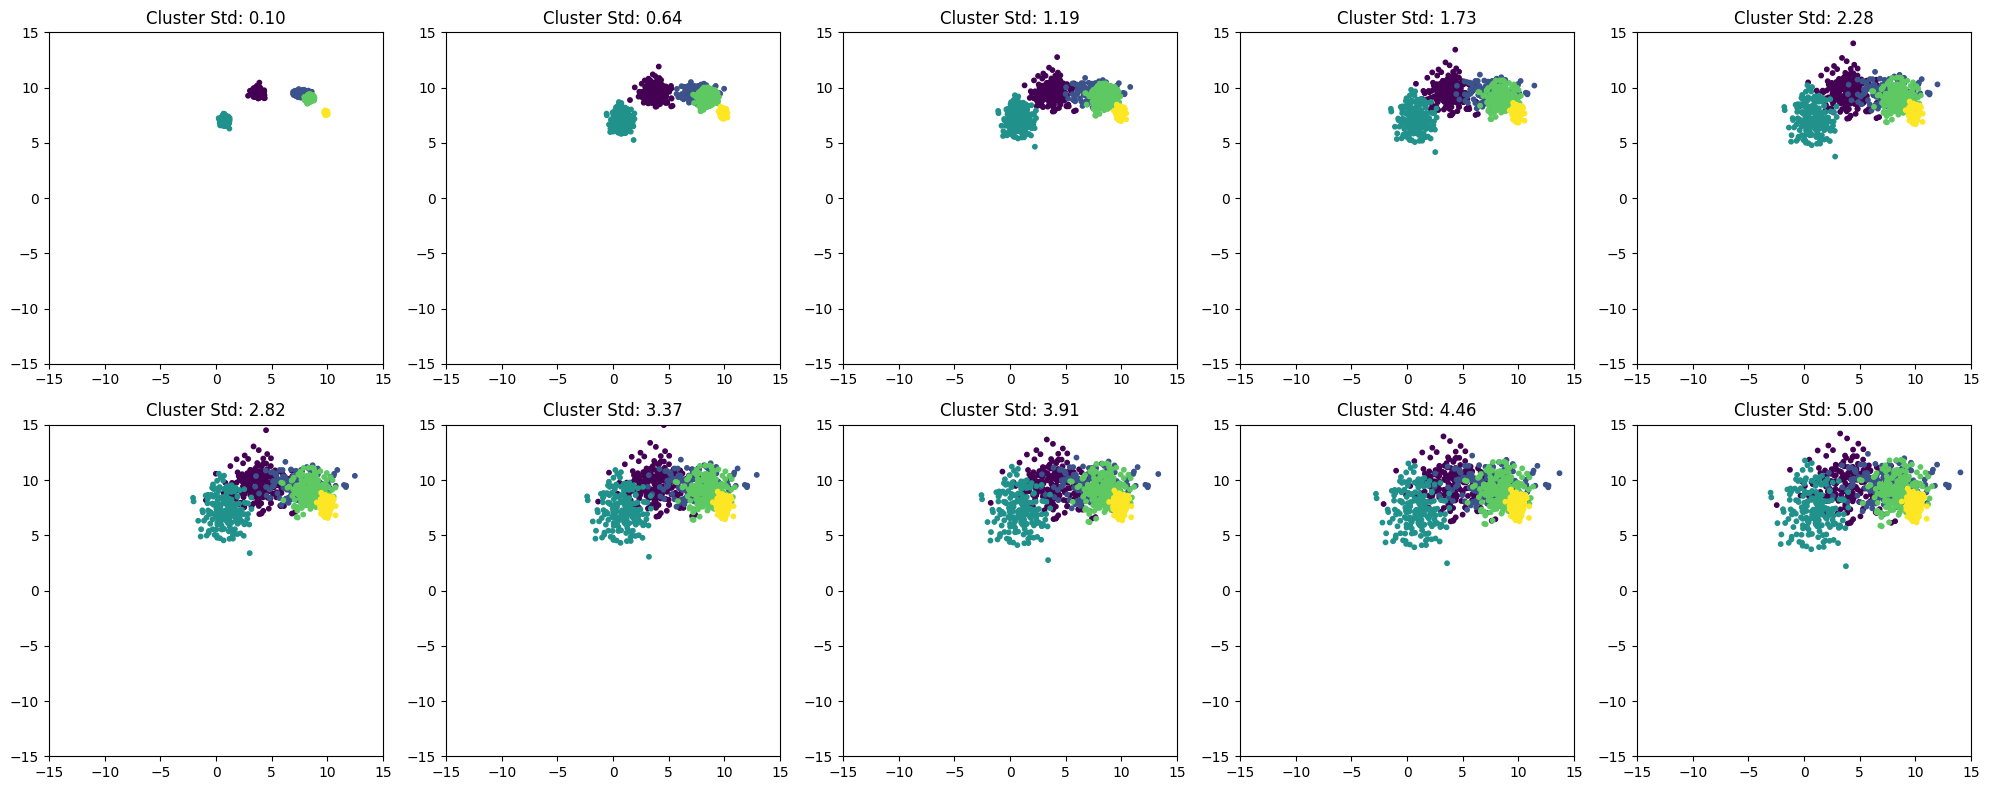

In [ ]:
# Configurações iniciais
n_samples = 1000
centers = 5
n_features = 2
cluster_stds = np.linspace(0.1, 5.0, 10)  # 10 valores de std variando de 0.1 a 5.0

# Geração dos 10 conjuntos de dados
datasets = []
for std in cluster_stds:
    X, y = generate_multivariate_normal_data(n_samples=n_samples, centers=centers, cluster_std=std, n_features=n_features)
    datasets.append((X, y))

# Visualizando os conjuntos de dados gerados
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (X, y) in enumerate(datasets):
    axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
    axes[i].set_title(f"Cluster Std: {cluster_stds[i]:.2f}")
    axes[i].set_xlim(-15, 15)
    axes[i].set_ylim(-15, 15)

plt.tight_layout()
plt.show()

# Dados Reais

## Função para Carregar os Dados

In [ ]:
# Função para carregar e padronizar datasets reais
def load_and_standardize_csv(filepath):
    # Carregar o dataset
    df = pd.read_csv(filepath, header=1)  # Ignorar a primeira linha que contém metadados

    # Extrair a primeira coluna como labels
    labels = df.iloc[:, 0].values

    # Usar as colunas restantes como features
    df_numeric = df.iloc[:, 1:]

    # Seleciona apenas colunas numéricas
    df_numeric = df_numeric.select_dtypes(include=[np.number])

    # Padronizar os dados numéricos
    standardized_data = StandardScaler().fit_transform(df_numeric)

    return standardized_data, labels

## Links para Obter os Dados

O dataset sobre genes a seguir deve ser baixado direto da fonte (~200MB)

- https://archive.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq

O restante abaixo está disponível no repositório do GitHub


- https://archive.ics.uci.edu/dataset/342/mice+protein+expression
- https://archive.ics.uci.edu/dataset/406/anuran+calls+mfccs
- https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition
- https://archive.ics.uci.edu/dataset/396/sales+transactions+dataset+weekly
- https://archive.ics.uci.edu/dataset/485/tarvel+review+ratings
- https://archive.ics.uci.edu/dataset/435/ble+rssi+dataset+for+indoor+localization+and+navigation
- https://archive.ics.uci.edu/dataset/470/parkinson+s+disease+classification
- https://archive.ics.uci.edu/dataset/484/travel+reviews
- https://archive.ics.uci.edu/dataset/334/wiki4he

## Carregamento dos Dados

In [ ]:
# Carregando os datasets reais
uci_datasets = {
    'cortex': load_and_standardize_csv('/content/Data_Cortex_Nuclear.csv'),
    'frogs': load_and_standardize_csv('/content/Frogs_MFCCs.csv'),
    'obesity': load_and_standardize_csv('/content/ObesityDataSet_raw_and_data_sinthetic.csv'),
    'sales': load_and_standardize_csv('/content/Sales_Transactions_Dataset_Weekly.csv'),
    'gene': load_and_standardize_csv('/content/gene_expression.csv'),
    'google': load_and_standardize_csv('/content/google_review_ratings.csv'),
    'ibeacon': load_and_standardize_csv('/content/iBeacon_RSSI_Unlabeled.csv'),
    'parkinson': load_and_standardize_csv('/content/parkinson_disease_speech_features.csv'),
    'tripadvisor': load_and_standardize_csv('/content/tripadvisor_review.csv'),
    'wiki4HE': load_and_standardize_csv('/content/wiki4HE.csv')
}

# ORIGINAL

In [ ]:
from sklearn.datasets import load_iris, load_wine, load_digits, load_breast_cancer, fetch_covtype, load_diabetes, load_linnerud, fetch_california_housing




# Geração de dados sintéticos
X_normal, _ = generate_multivariate_normal_data(n_samples=1000, centers=5, cluster_std=1.5, n_features=2)
X_varied, _ = generate_multivariate_normal_data(n_samples=1000, centers=5, cluster_std=3.0, n_features=2)

# Carrega e padroniza os datasets
iris_data = StandardScaler().fit_transform(load_iris().data[:1000])
wine_data = StandardScaler().fit_transform(load_wine().data[:1000])
digits_data = StandardScaler().fit_transform(load_digits().data[:1000])
breast_cancer_data = StandardScaler().fit_transform(load_breast_cancer().data[:1000])
covtype_data = StandardScaler().fit_transform(fetch_covtype().data[:1000])
diabetes_data = StandardScaler().fit_transform(load_diabetes().data[:1000])
california_housing_data = StandardScaler().fit_transform(fetch_california_housing().data[:1000])
linnerud_data = StandardScaler().fit_transform(load_linnerud().data[:1000])


datasets = {
    'synthetic_normal': {
        'data': X_normal,
        'n_clusters': 5
    },
    'synthetic_varied': {
        'data': X_varied,
        'n_clusters': 5
    },
    'iris': {
        'data': iris_data,
        'n_clusters': 3
    },
    'wine': {
        'data': wine_data,
        'n_clusters': 3
    },
    'breast_cancer': {
        'data': breast_cancer_data,
        'n_clusters': 2
    },
    'covtype': {
        'data': covtype_data,
        'n_clusters': 7
    },
    'diabetes': {
        'data': diabetes_data,
        'n_clusters': 3
    },
    'california_housing': {
        'data': california_housing_data,
        'n_clusters': 8
    },
    'linnerud': {
        'data': linnerud_data,
        'n_clusters': 3
    }
}

# Loop para testar cada dataset hardcoded
for name, dataset in datasets.items():
    print(f"\nExecutando teste no conjunto de dados: {name}")
    X = dataset['data']
    n_clusters = dataset['n_clusters']

    # Testando diferentes valores de p
    for p in [1, 2]:  # Distância Manhattan e Euclidiana
        print(f"\nTestando com p={p}")

        silhouette_fixed_results = []
        ari_fixed_results = []
        time_fixed_results = []

        refinement_factors = [1.01, 1.05, 1.1, 1.15, 1.25]
        silhouette_refined_results = {rf: [] for rf in refinement_factors}
        ari_refined_results = {rf: [] for rf in refinement_factors}
        time_refined_results = {rf: [] for rf in refinement_factors}

        silhouette_kmeans_results = []
        ari_kmeans_results = []
        time_kmeans_results = []

        for _ in range(30):  # Executar 30 vezes para capturar a variação
            # Ajustar o raio
            if p == 1:
                initial_radius = calculate_initial_radius(X, sample_size=1000) * 5  # Aumentando o raio mais significativamente para p=1
            else:
                initial_radius = calculate_initial_radius(X, sample_size=1000) * 2  # Aumentando o raio para p=2

            # Executa o algoritmo 2-aproximado com raio fixo
            start_time = time.time()
            centers_fixed = two_approx_k_center_fixed_radius(X, radius=initial_radius, p=p)
            time_fixed = time.time() - start_time

            # Verifica se o número de centros encontrados é válido
            if len(centers_fixed) < 2 or len(centers_fixed) >= len(X):
                print(f"Erro: Número de clusters inválido ({len(centers_fixed)}) para o conjunto de dados {name} com p={p}.")
                break  # Se inválido, sair do loop
            else:
                try:
                    silhouette_fixed, ari_fixed = evaluate_clustering(X, centers_fixed, p=p)
                    silhouette_fixed_results.append(silhouette_fixed)
                    ari_fixed_results.append(ari_fixed)
                    time_fixed_results.append(time_fixed)
                except ValueError as e:
                    print(f"Erro ao calcular métricas para 2-Aproximado (Raio Fixo): {e}")
                    break  # Se houver erro, sair do loop

            # Executa o algoritmo 2-aproximado com refinamento de raio para cada fator
            for rf in refinement_factors:
                start_time = time.time()
                centers_refined = two_approx_k_center_refined_radius(X, initial_radius=initial_radius, refinement_factor=rf, max_iters=3, p=p)
                time_refined = time.time() - start_time

                # Verifica se o número de centros encontrados é válido
                if len(centers_refined) < 2 or len(centers_refined) >= len(X):
                    print(f"Erro: Número de clusters inválido ({len(centers_refined)}) para o conjunto de dados {name} com p={p}.")
                    break  # Se inválido, sair do loop
                else:
                    try:
                        silhouette_refined, ari_refined = evaluate_clustering(X, centers_refined, p=p)
                        silhouette_refined_results[rf].append(silhouette_refined)
                        ari_refined_results[rf].append(ari_refined)
                        time_refined_results[rf].append(time_refined)
                    except ValueError as e:
                        print(f"Erro ao calcular métricas para 2-Aproximado (Raio Refinado): {e}")
                        break  # Se houver erro, sair do loop

            # Executa o K-Means com n_init explicitamente definido
            start_time = time.time()
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans.fit(X)
            time_kmeans = time.time() - start_time

            silhouette_kmeans = silhouette_score(X, kmeans.labels_)
            ari_kmeans = adjusted_rand_score(kmeans.labels_, kmeans.labels_)
            silhouette_kmeans_results.append(silhouette_kmeans)
            ari_kmeans_results.append(ari_kmeans)
            time_kmeans_results.append(time_kmeans)

        # Calcula e exibe as médias e desvios padrões
        print(f"\nResultados para p={p}:")
        print(f"2-Aproximado (Raio Fixo): Silhueta média={np.mean(silhouette_fixed_results):.4f}, Desvio padrão={np.std(silhouette_fixed_results):.4f}, ARI média={np.mean(ari_fixed_results):.4f}, Tempo médio={np.mean(time_fixed_results):.4f} segundos")

        for rf in refinement_factors:
            print(f"2-Aproximado (Raio Refinado, Refinamento={rf}): Silhueta média={np.mean(silhouette_refined_results[rf]):.4f}, Desvio padrão={np.std(silhouette_refined_results[rf]):.4f}, ARI média={np.mean(ari_refined_results[rf]):.4f}, Tempo médio={np.mean(time_refined_results[rf]):.4f} segundos")

        print(f"K-Means: Silhueta média={np.mean(silhouette_kmeans_results):.4f}, Desvio padrão={np.std(silhouette_kmeans_results):.4f}, ARI média={np.mean(ari_kmeans_results):.4f}, Tempo médio={np.mean(time_kmeans_results):.4f} segundos")


Executando teste no conjunto de dados: synthetic_normal

Testando com p=1

Resultados para p=1:
2-Aproximado (Raio Fixo): Silhueta média=0.5195, Desvio padrão=0.0000, ARI média=1.0000, Tempo médio=0.0184 segundos
2-Aproximado (Raio Refinado, Refinamento=1.01): Silhueta média=0.5420, Desvio padrão=0.0000, ARI média=1.0000, Tempo médio=0.0677 segundos
2-Aproximado (Raio Refinado, Refinamento=1.05): Silhueta média=0.5420, Desvio padrão=0.0000, ARI média=1.0000, Tempo médio=0.0715 segundos
2-Aproximado (Raio Refinado, Refinamento=1.1): Silhueta média=0.5836, Desvio padrão=0.0000, ARI média=1.0000, Tempo médio=0.0708 segundos
2-Aproximado (Raio Refinado, Refinamento=1.15): Silhueta média=0.5994, Desvio padrão=0.0000, ARI média=1.0000, Tempo médio=0.0722 segundos
2-Aproximado (Raio Refinado, Refinamento=1.25): Silhueta média=0.4893, Desvio padrão=0.0000, ARI média=1.0000, Tempo médio=0.0886 segundos
K-Means: Silhueta média=0.5026, Desvio padrão=0.0000, ARI média=1.0000, Tempo médio=0.0561 s